In [1]:
# imports

from __future__ import print_function, division
import os
import pandas as pd
import numpy as np
import datetime
import dateutil
import math
from pandas.tseries import offsets
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.misc import derivative
from scipy.optimize import minimize
from scipy.optimize import leastsq
import re
from scipy import interpolate
from decimal import *
getcontext().prec = 20

import statsmodels.api as sm
from statsmodels import tsa
#from datetime import date, datetime, timedelta
import copy

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates


# Plotting and display options
np.set_printoptions(precision=5)
pd.set_option('precision', 4)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

plt.style.use('ggplot')

mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

# figure configuration
fsize = (12,8) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

# this allows plots to appear directly in the notebook
%matplotlib inline

/Users/lixinyan/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### get the start date and end date for the data used

In [2]:
rf=pd.read_csv('./data/DGS3MO.csv')
rf.columns=['Date','rt']
print('start date:', rf.Date.values[0], 'end_date', rf.Date.values[-1])

start date: 1982-01-04 end_date 2018-02-22


In [3]:
df=pd.read_csv('./data/^GSPC.csv')
print('start date:', df.Date.values[0], 'end_date', df.Date.values[-1])

start date: 1980-01-02 end_date 2018-02-21


In [4]:
df=pd.read_csv('./data/^N225.csv')
print('start date:', df.Date.values[0], 'end_date', df.Date.values[-1])

start date: 1980-01-04 end_date 2018-02-22


In [5]:
df=pd.read_csv('./data/^STOXX50E.csv')
print('start date:', df.Date.values[0], 'end_date', df.Date.values[-1])

start date: 1986-12-31 end_date 2018-02-22


In [6]:
df=pd.read_csv('./data/^GDAXI.csv')
print('start date:', df.Date.values[0], 'end_date', df.Date.values[-1])

start date: 1987-12-30 end_date 2018-02-22


In [7]:
df=pd.read_csv('./data/^FCHI.csv')
print('start date:', df.Date.values[0], 'end_date', df.Date.values[-1])

start date: 1990-03-01 end_date 2018-02-22


### read in data

In [8]:
# risk-free rate
rf=pd.read_csv('./data/DGS3MO.csv')
rf.columns=['Date','rt']
rf.Date=pd.to_datetime(rf.Date)
rf=rf.sort_values(['Date']).reset_index(drop=True)
rf=rf.set_index('Date')
rf.rt=pd.to_numeric(rf.rt, errors='coerce')/100
#convert the risk-free rate to a daily rate
rf.rt=np.power(rf.rt+1,1/360)-1

#US: S&P500
df=pd.read_csv('./data/^GSPC.csv')
df=df[['Date','Adj Close']]
df.columns=['Date','Adj_Close']
df.Date=pd.to_datetime(df.Date)
df=df.sort_values(['Date']).reset_index(drop=True)
df=df.set_index('Date')
df_l=df.shift()
df['Adj_Close_l']=df_l.Adj_Close
df['rt']=(df.Adj_Close-df.Adj_Close_l)/df.Adj_Close_l

#match the risk-free rate with the equity index return

df['rf']=rf.rt
df['ex_rt']=df.rt-df.rf
df=df.dropna(axis=0, how='any')
df.reset_index(level=0, inplace=True)

#split the date

df['year']=df.Date.apply(lambda x: x.year)
df['month']=df.Date.apply(lambda x: x.month)
df['day']=df.Date.apply(lambda x: x.day)

In [9]:
#read and clean data
def data_read_clean(rf_path, index_path):
    # risk-free rate
    rf=pd.read_csv(rf_path)
    rf.columns=['Date','rt']
    rf.Date=pd.to_datetime(rf.Date)
    rf=rf.sort_values(['Date']).reset_index(drop=True)
    rf=rf.set_index('Date')
    rf.rt=pd.to_numeric(rf.rt, errors='coerce')/100
    #convert the risk-free rate to a daily rate
    rf.rt=np.power(rf.rt+1,1/360)-1

    #US: S&P500
    df=pd.read_csv(index_path)
    df=df[['Date','Adj Close']]
    df.columns=['Date','Adj_Close']
    df.Date=pd.to_datetime(df.Date)
    df=df.sort_values(['Date']).reset_index(drop=True)
    df=df.set_index('Date')
    df_l=df.shift()
    df['Adj_Close_l']=df_l.Adj_Close
    df['rt']=(df.Adj_Close-df.Adj_Close_l)/df.Adj_Close_l

    #match the risk-free rate with the equity index return

    df['rf']=rf.rt
    df['ex_rt']=df.rt-df.rf
    df=df.dropna(axis=0, how='any')
    df.reset_index(level=0, inplace=True)

    #split the date

    df['year']=df.Date.apply(lambda x: x.year)
    df['month']=df.Date.apply(lambda x: x.month)
    df['day']=df.Date.apply(lambda x: x.day)
    return df

In [10]:
#get the monthly average return

def month_rt_get(df):
    
    year_list=np.sort(df.year.unique())

    neg=['T-'+str(i) for i in np.arange(10,0,-1)]
    pos=['T+'+str(i) for i in np.arange(1,11,1)]

    col_names=['year','month'] + neg + ['T'] + pos
    ind=1
    for year in year_list:
        month_list=np.sort(df.loc[df.year==year].month.unique())
        for month in month_list:
            temp_ave=pd.DataFrame(np.zeros((1,len(col_names))), columns=col_names)
            df_sub=df.loc[(df.year==year)&(df.month==month)]
            last=df_sub.tail(1).index[0]
            temp_ave.year[0]=year
            temp_ave.month[0]=month
            if len(df.iloc[(last-10):(last+11),:].ex_rt.values)==21:
                temp_ave.iloc[0,2:]=df.iloc[(last-10):(last+11),:].ex_rt.values
                if ind==1:
                    df_ave=temp_ave
                    ind=0
                else:
                    df_ave=df_ave.append(temp_ave)
                    
    df_ave=df_ave.reset_index(drop=True)
    return df_ave

In [11]:
#get the yearly average return for days in [T-10, T+10]
def year_rt_plot(df_ave, n, ct):
    df_ave_y=df_ave.groupby(['year'], as_index=False).mean()
    year_list=df_ave_y.year.unique()

    plot_num=int(len(df_ave_y)/n)+1
    col_names=df_ave_y.columns

    for i in np.arange(plot_num):
        df_ave_sub=df_ave_y.iloc[(n*i):(n*(i+1)),:].reset_index(drop=True)
        plt.figure(i,(10,3))
        year_list=df_ave_sub.year.unique()

        for year in year_list:

            df_ave_sub_sub=df_ave_sub.loc[df_ave_sub.year==year]
            plt.plot(df_ave_sub_sub.iloc[0,2:].values)

            plt.xticks(np.arange(len(col_names[2:])),col_names[2:])
        plt.axhline(y=0, xmin=0, xmax=22, ls='dashed')
        plt.legend([str(i) for i in year_list])
        plt.title(ct + ' yearly average return')
    return df_ave_y

def general_rt_plot(df_ave_y, ct):
    year_list=df_ave_y.year.unique()
    col_names=df_ave_y.columns
    plt.figure(0,(10,3))
    plt.plot(df_ave_y.mean()[2:].values)
    plt.xticks(np.arange(len(col_names[2:])),col_names[2:])
    plt.axhline(y=0, xmin=0, xmax=22, ls='dashed')
    plt.title(ct + ' general average return' + ': ' + str(year_list[0])[:4] + ' - ' + str(year_list[-1])[:4])
    
    plot_path='./plot/' + ct+'_general.jpg'
    plt.savefig(plot_path)

In [12]:
# test the trading rule: buy the index on T-4 and sell it on T+1, 
# then could collect the positive return from T-3 to T+1

def trade_rule(df_ave):
    df_ave['td_rt']=(1+df_ave['T-3'])*(1+df_ave['T-2'])*(1+df_ave['T-1'])*(1+df_ave['T'])*(1+df_ave['T+1'])
    df_ave['cum_rt']=np.cumprod(df_ave.td_rt)-1
    df_ave['date']=[str(int(df_ave.year[i]))+'-' + str(int(df_ave.month[i])) for i in range(len(df_ave))]
    df_ave.date=pd.to_datetime(df_ave.date)
    df_ave_new=df_ave.set_index('date')
    year_list=df_ave.year.unique()
    plt.figure(0,(10,3))
    plt.plot(df_ave_new.cum_rt)
    plt.axhline(y=0, xmin=0, xmax=len(df_ave.cum_rt), ls='dashed')
    plt.title(ct + ' cum trading return' + ': ' + str(year_list[0])[:4] + ' - ' + str(year_list[-1])[:4])
    plot_path='./plot/' + ct+'_cum_rt.jpg'
    plt.savefig(plot_path)
    print('The cum return for '+ ct + ' is:',df_ave_new.cum_rt[-1])
    sr=np.mean(df_ave.td_rt-1)/np.std(df_ave.td_rt-1)*np.power(12,1/2)
    print('The SR for '+ ct + ' is:',sr)

# US: S&P 500

### Yearly average of the daily excess returns in [T-10, T+10]

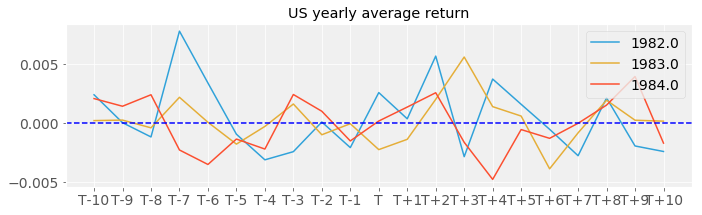

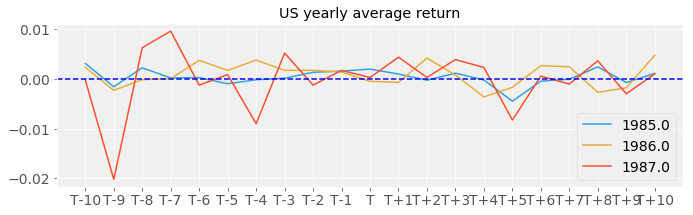

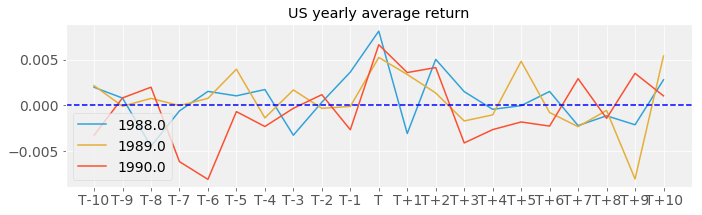

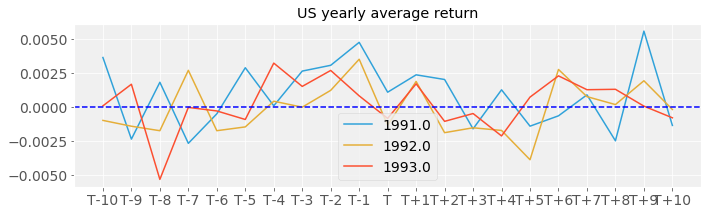

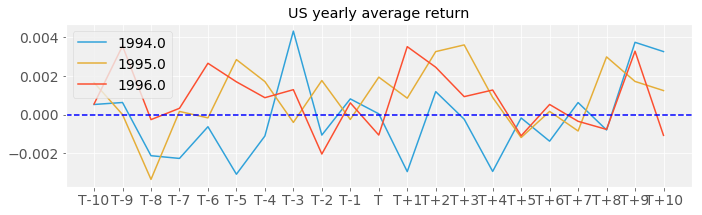

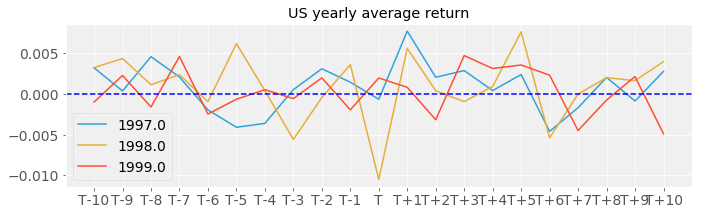

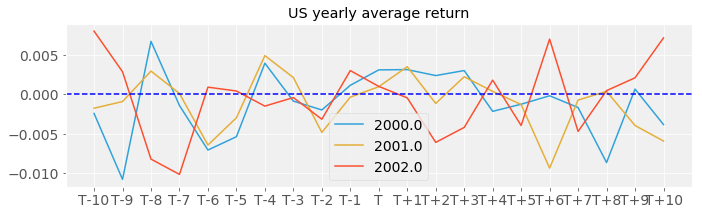

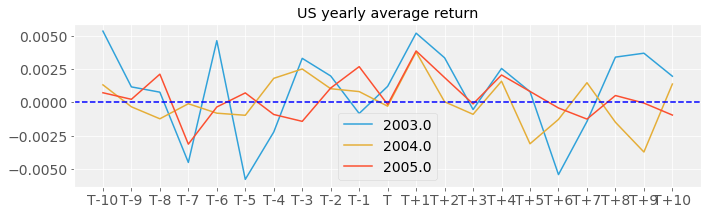

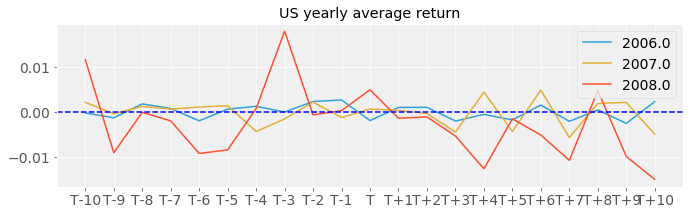

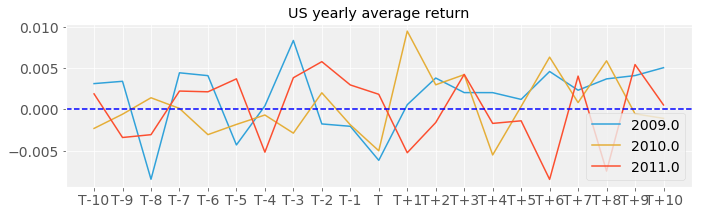

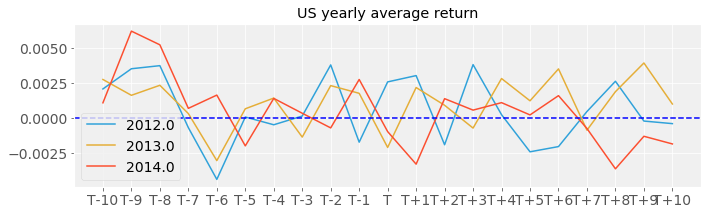

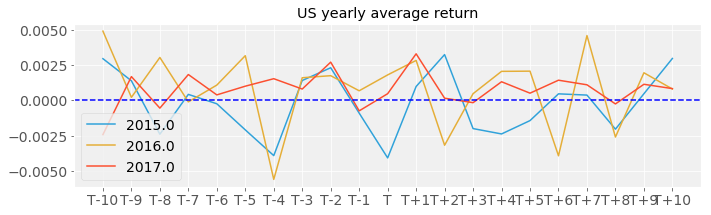

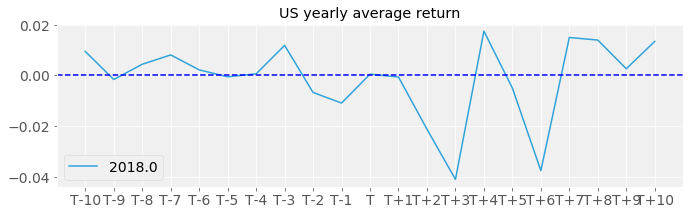

In [13]:
rf_path='./data/DGS3MO.csv'
index_path='./data/^GSPC.csv'
df=data_read_clean(rf_path, index_path)
df_ave=month_rt_get(df)
n=3
ct='US'
df_ave_y=year_rt_plot(df_ave, n, ct)

### General average of the daily excess returns in [T-10, T+10]

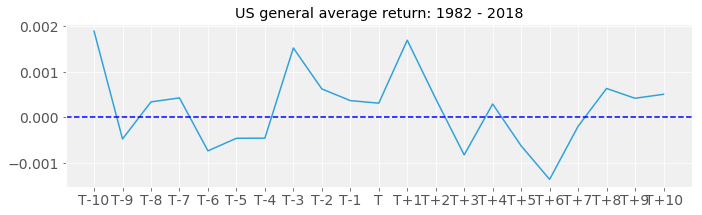

In [15]:
general_rt_plot(df_ave_y, ct)

### The back test of the trading rule

The cum return for US is: 6.003397932621867
The SR for US is: 0.7356202492659095


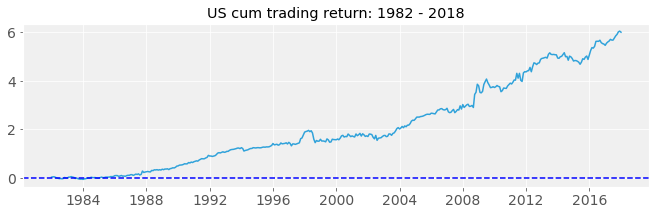

In [16]:
trade_rule(df_ave)

# Japan: Nikkei 225

### Yearly average of the daily excess returns in [T-10, T+10]

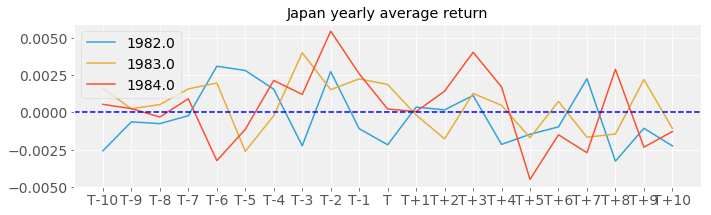

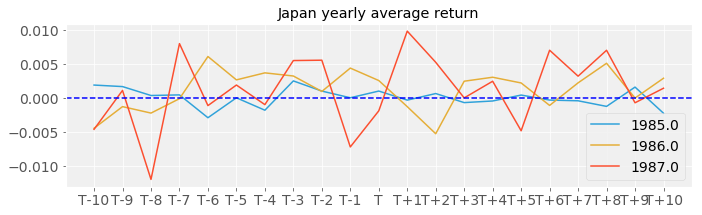

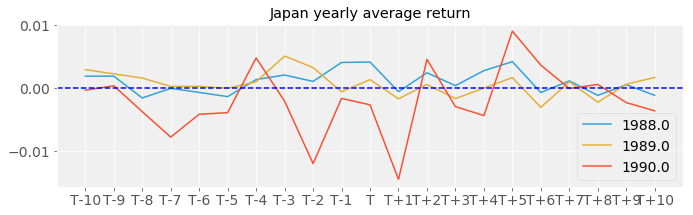

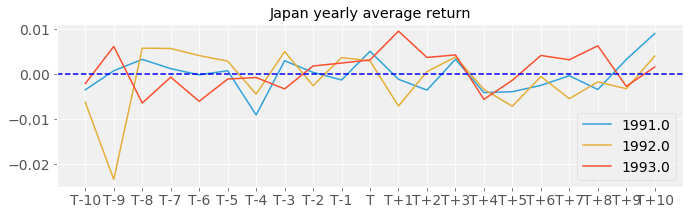

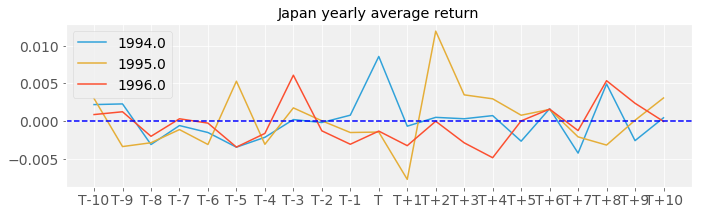

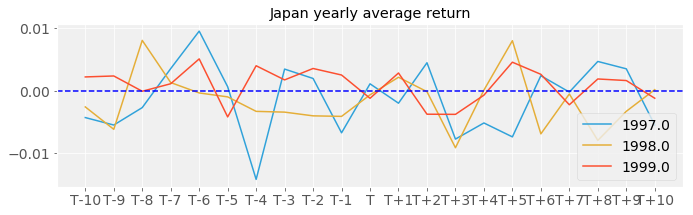

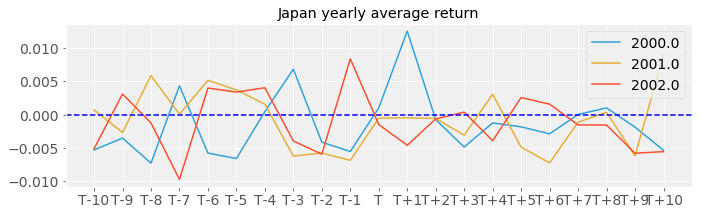

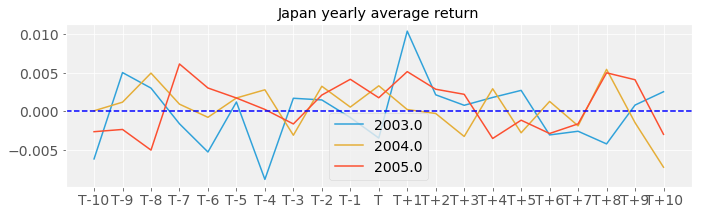

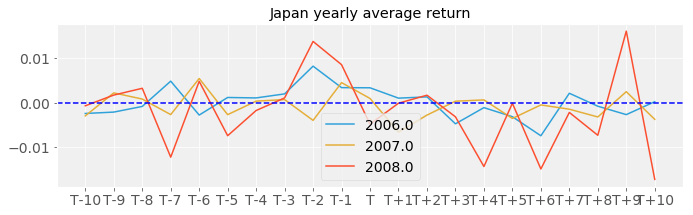

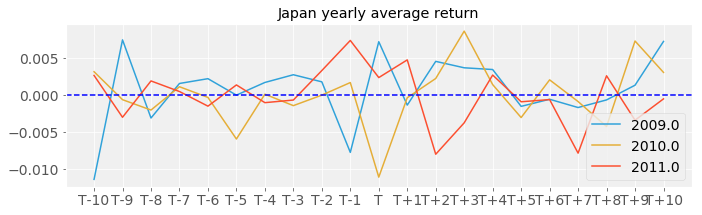

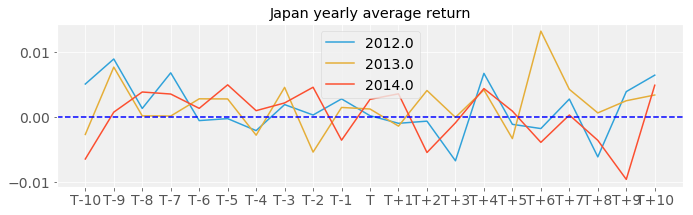

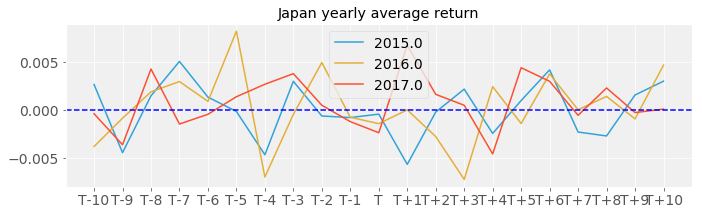

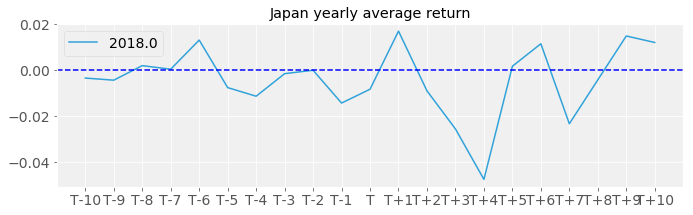

In [17]:
rf_path='./data/DGS3MO.csv'
index_path='./data/^N225.csv'
df=data_read_clean(rf_path, index_path)
df_ave=month_rt_get(df)
n=3
ct='Japan'
df_ave_y=year_rt_plot(df_ave, n, ct)

### General average of the daily excess returns in [T-10, T+10]

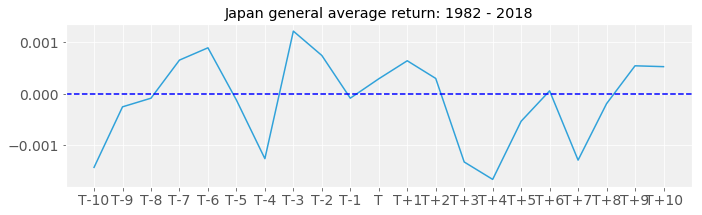

In [18]:
general_rt_plot(df_ave_y, ct)

### The back test of the trading rule

The cum return for Japan is: 2.0863395981978083
The SR for Japan is: 0.3358732715867084


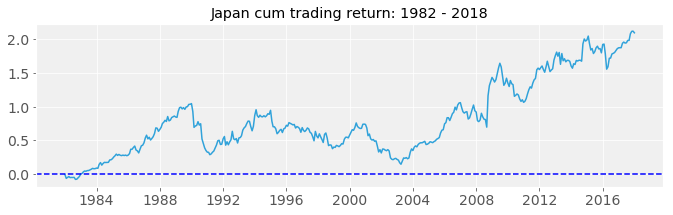

In [19]:
trade_rule(df_ave)

# Europe: ESTX50 EUR P

### Yearly average of the daily excess returns in [T-10, T+10]

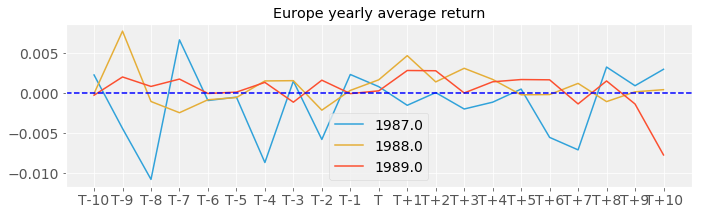

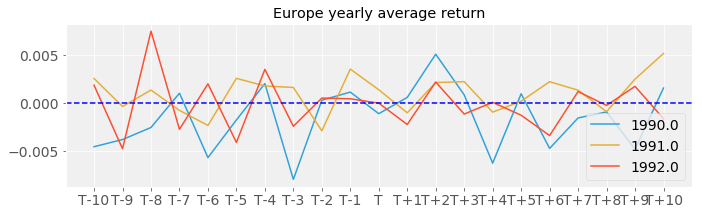

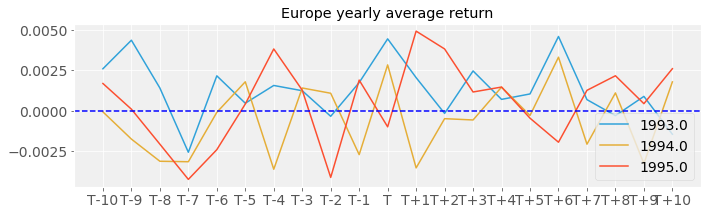

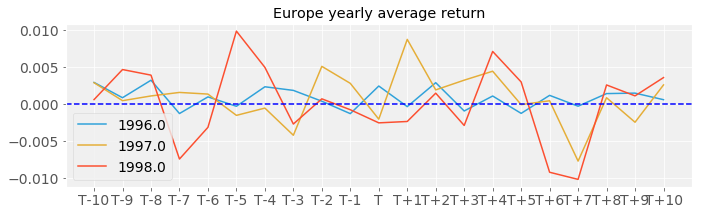

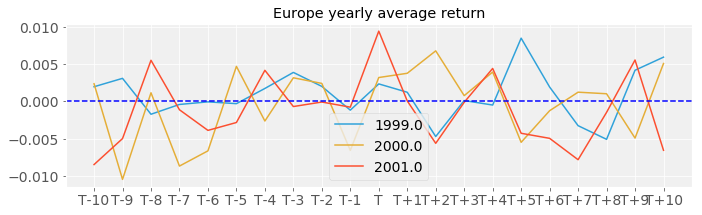

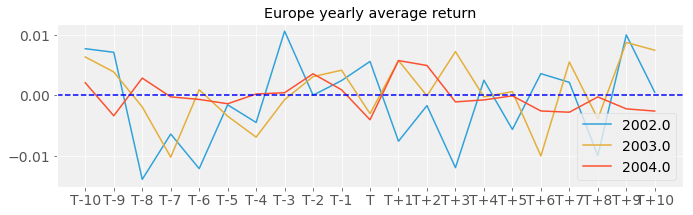

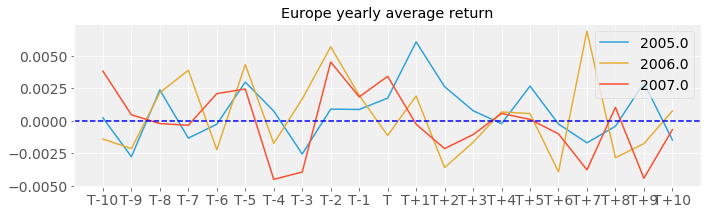

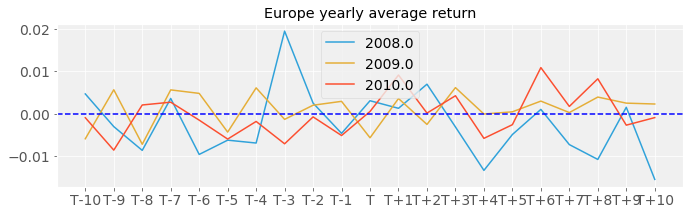

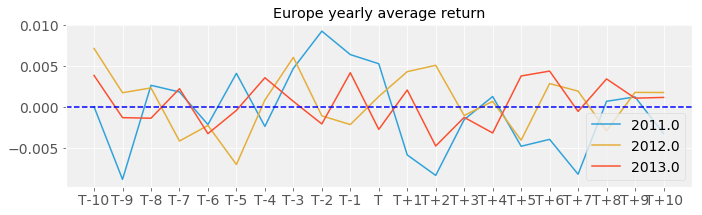

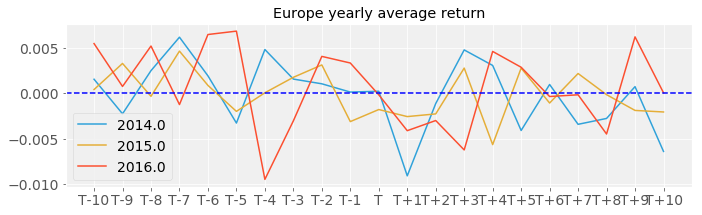

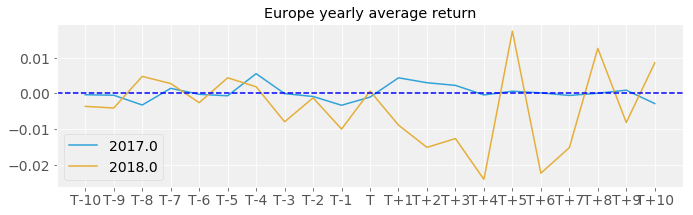

In [20]:
rf_path='./data/DGS3MO.csv'
index_path='./data/^STOXX50E.csv'
df=data_read_clean(rf_path, index_path)
df_ave=month_rt_get(df)
n=3
ct='Europe'
df_ave_y=year_rt_plot(df_ave, n, ct)

### General average of the daily excess returns in [T-10, T+10]

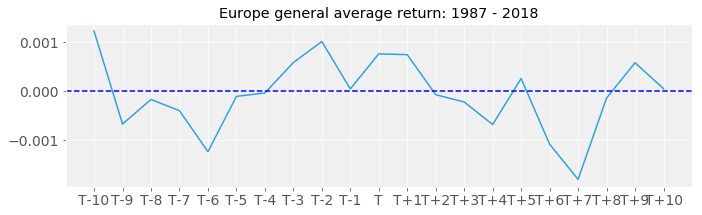

In [21]:
general_rt_plot(df_ave_y, ct)

### The back test of the trading rule

The cum return for Europe is: 2.8718885441373967
The SR for Europe is: 0.5207341684397315


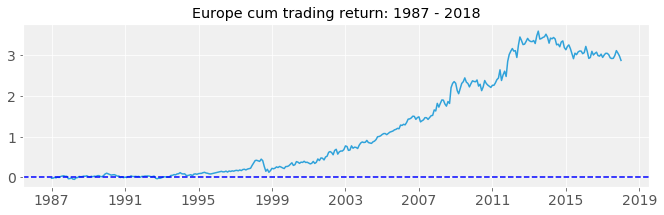

In [22]:
trade_rule(df_ave)

# German: DAX

### Yearly average of the daily excess returns in [T-10, T+10]

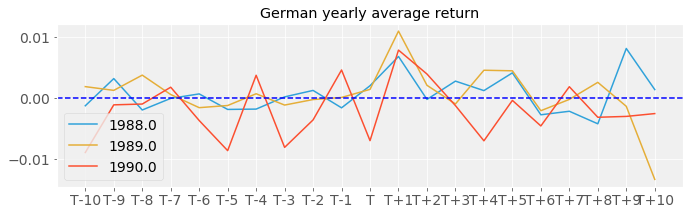

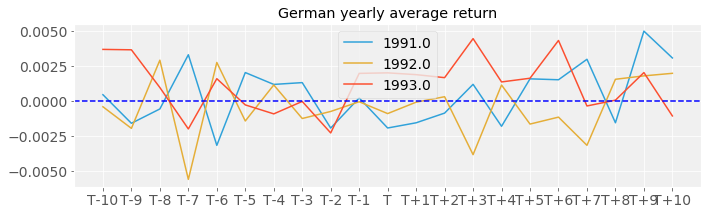

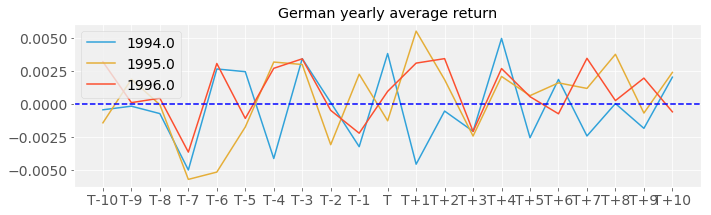

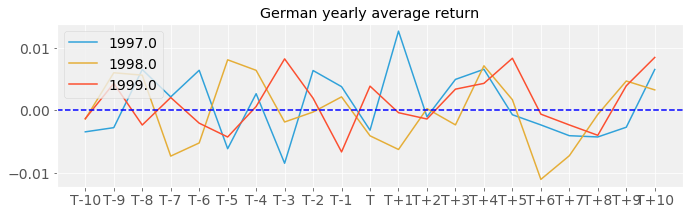

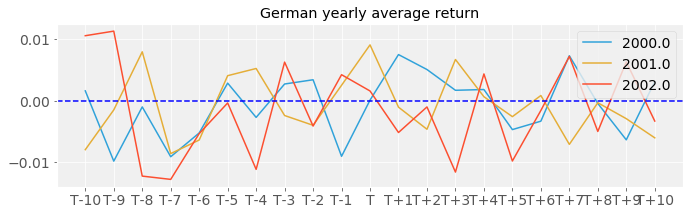

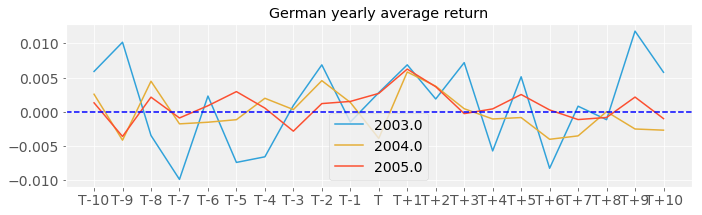

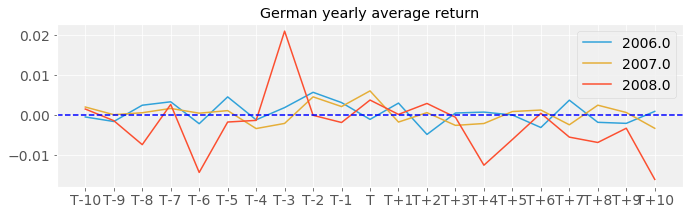

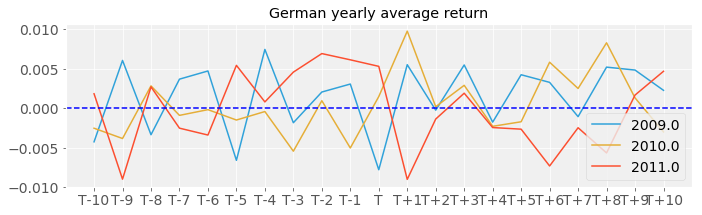

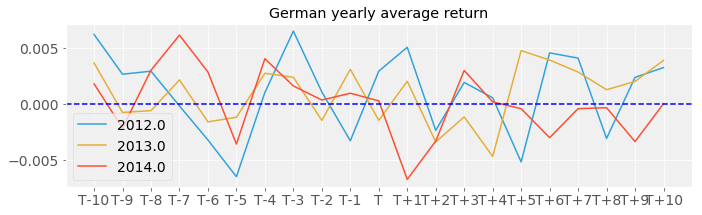

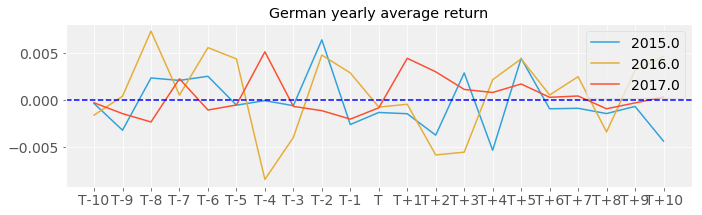

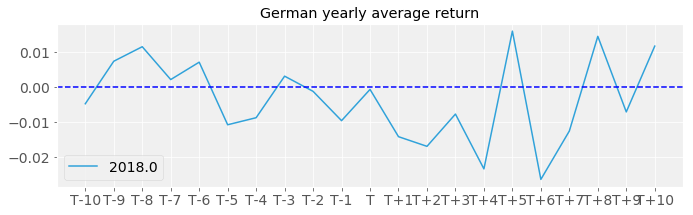

In [23]:
rf_path='./data/DGS3MO.csv'
index_path='./data/^GDAXI.csv'
df=data_read_clean(rf_path, index_path)
df_ave=month_rt_get(df)
n=3
ct='German'
df_ave_y=year_rt_plot(df_ave, n, ct)

### General average of the daily excess returns in [T-10, T+10]

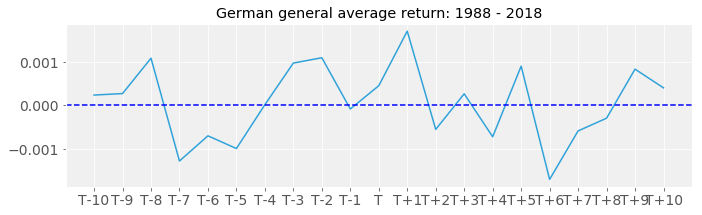

In [24]:
general_rt_plot(df_ave_y, ct)

### The back test of the trading rule

The cum return for German is: 3.9836771336982375
The SR for German is: 0.5903419721527653


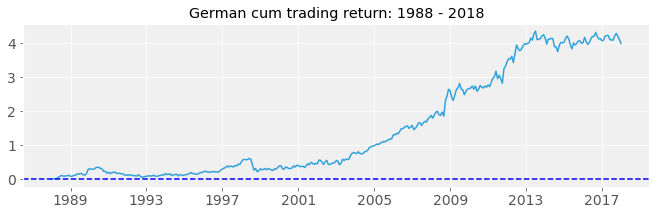

In [25]:
trade_rule(df_ave)

# France: CAC

### Yearly average of the daily excess returns in [T-10, T+10]

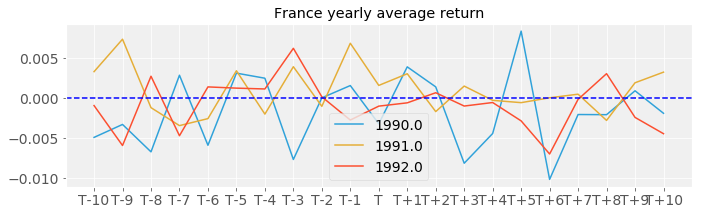

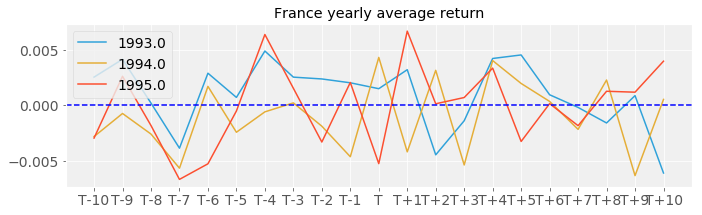

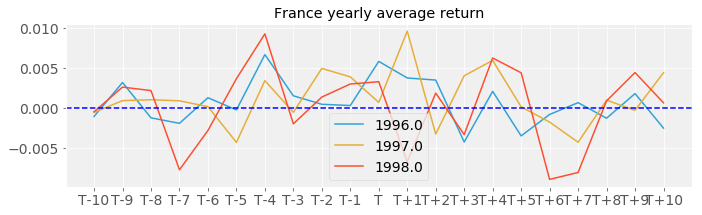

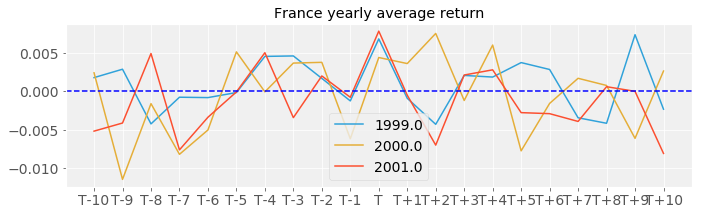

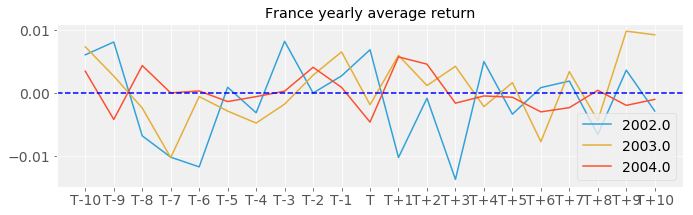

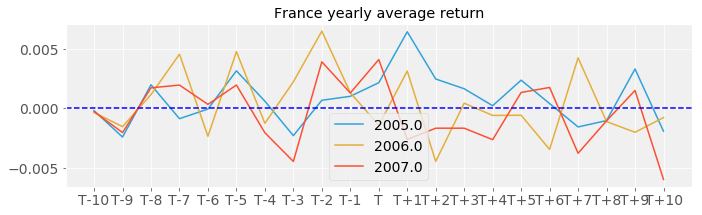

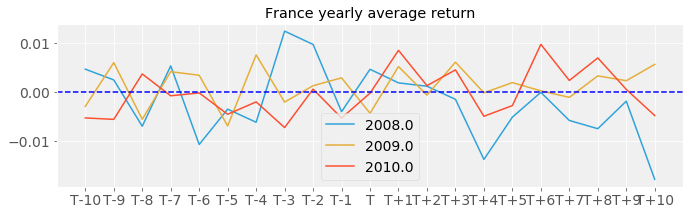

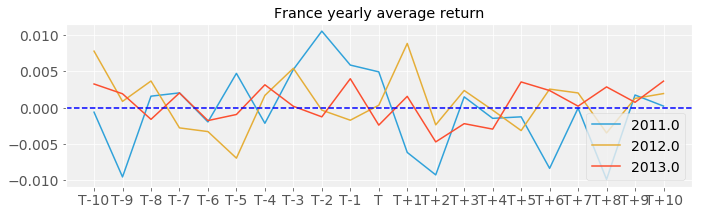

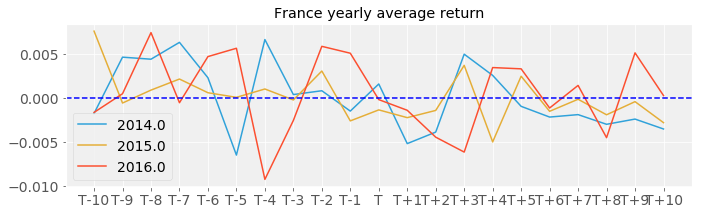

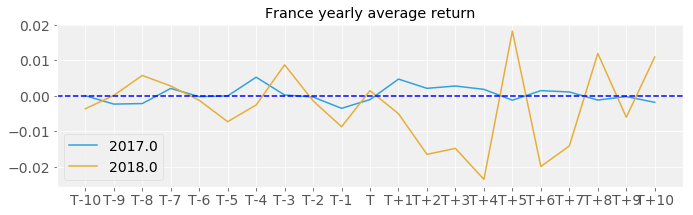

In [26]:
rf_path='./data/DGS3MO.csv'
index_path='./data/^FCHI.csv'
df=data_read_clean(rf_path, index_path)
df_ave=month_rt_get(df)
n=3
ct='France'
df_ave_y=year_rt_plot(df_ave, n, ct)

### General average of the daily excess returns in [T-10, T+10]

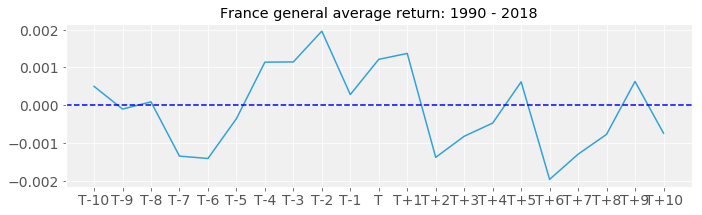

In [29]:
general_rt_plot(df_ave_y, ct)

### The back test of the trading rule

The cum return for France is: 6.297835320993731
The SR for France is: 0.7527984911710999


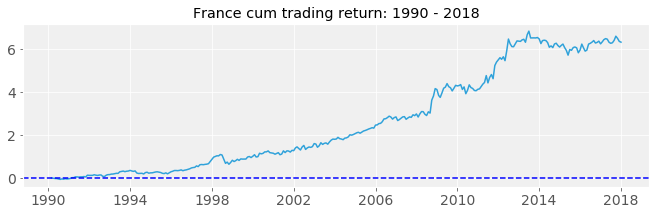

In [30]:
trade_rule(df_ave)

# Hong Kong District: HANG SENG INDEX

### Yearly average of the daily excess returns in [T-10, T+10]

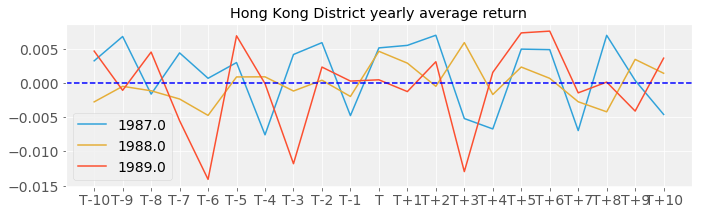

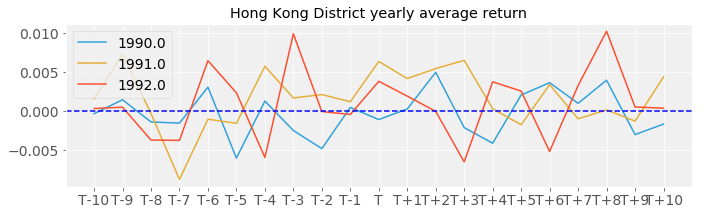

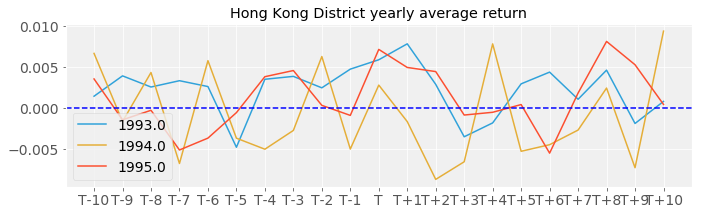

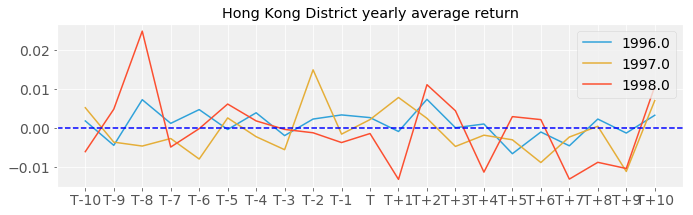

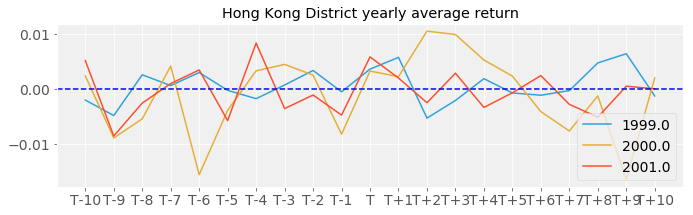

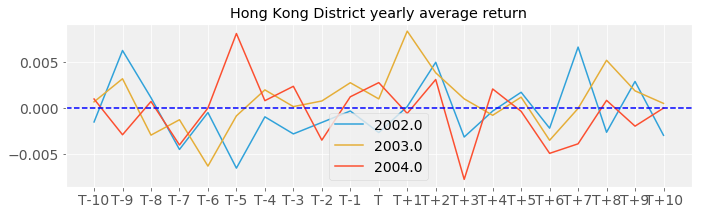

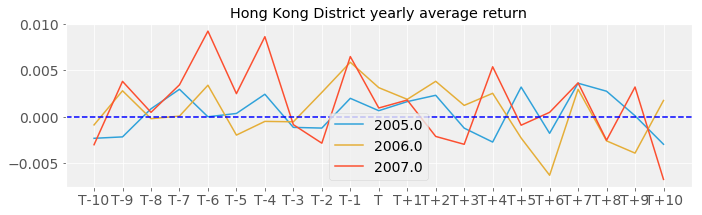

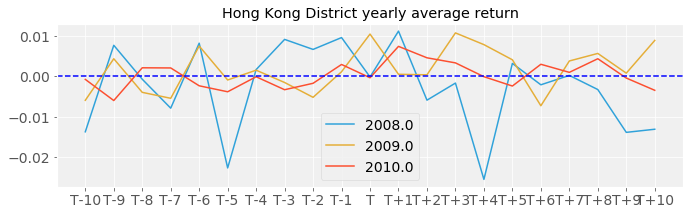

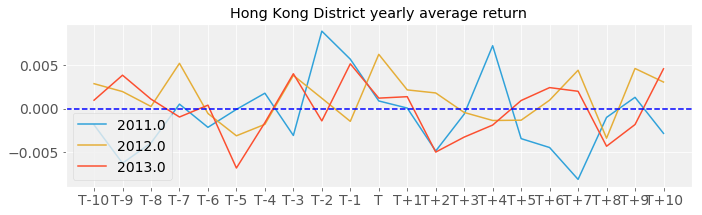

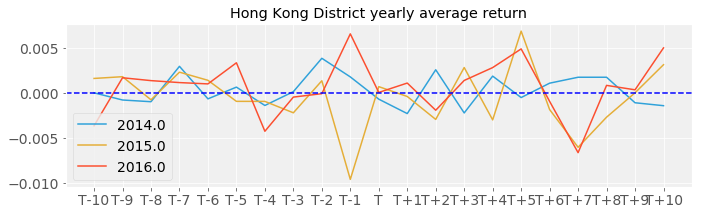

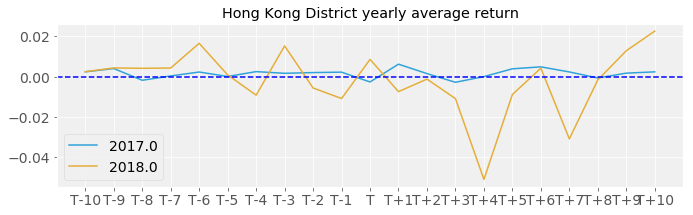

In [31]:
rf_path='./data/DGS3MO.csv'
index_path='./data/^HSI.csv'
df=data_read_clean(rf_path, index_path)
df_ave=month_rt_get(df)
n=3
ct='Hong Kong District'
df_ave_y=year_rt_plot(df_ave, n, ct)

### General average of the daily excess returns in [T-10, T+10]

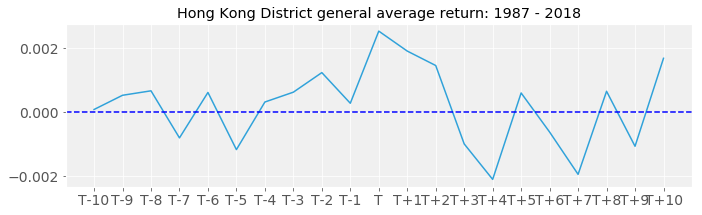

In [32]:
general_rt_plot(df_ave_y, ct)

### The back test of the trading rule

The cum return for Hong Kong District is: 9.163039366706043
The SR for Hong Kong District is: 0.6731556397903399


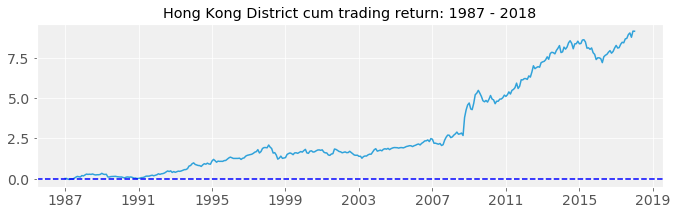

In [33]:
trade_rule(df_ave)

# China: SSE Composite Index

### Yearly average of the daily excess returns in [T-10, T+10]

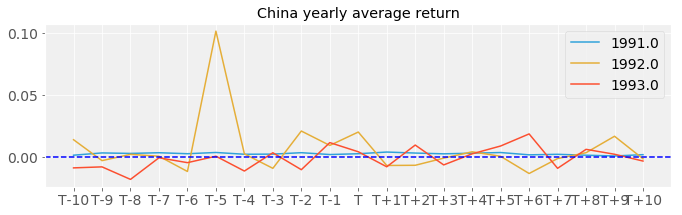

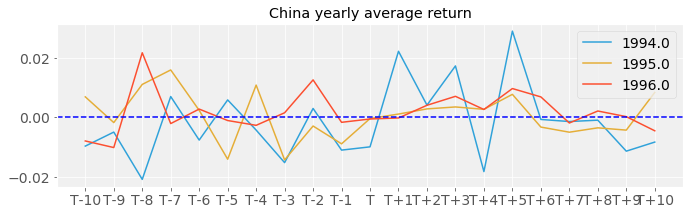

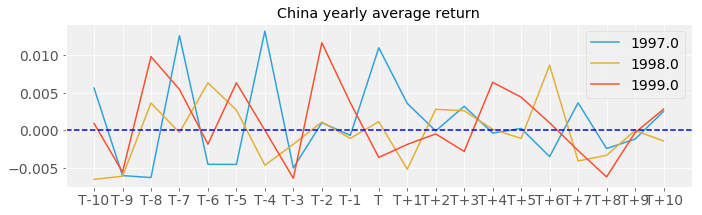

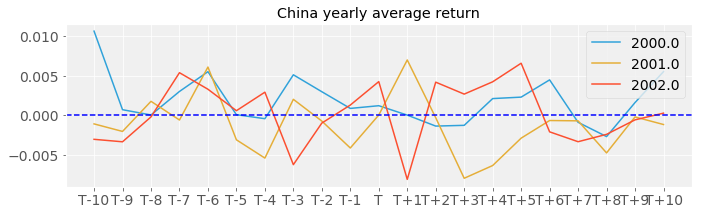

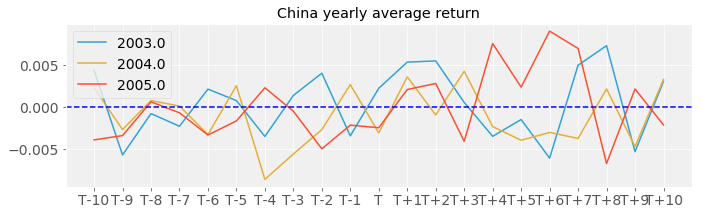

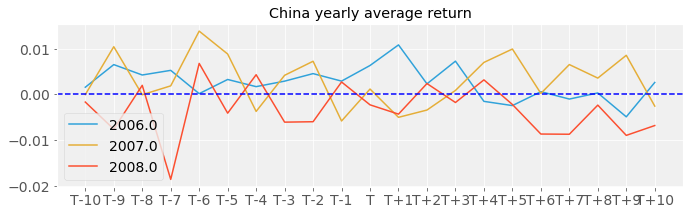

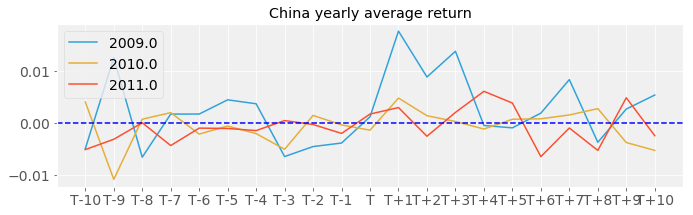

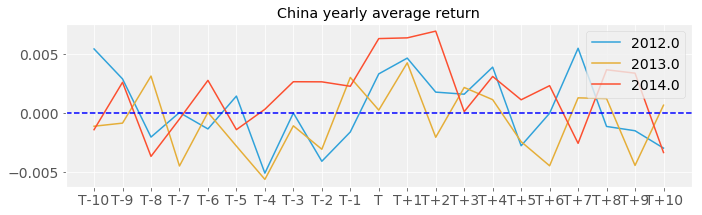

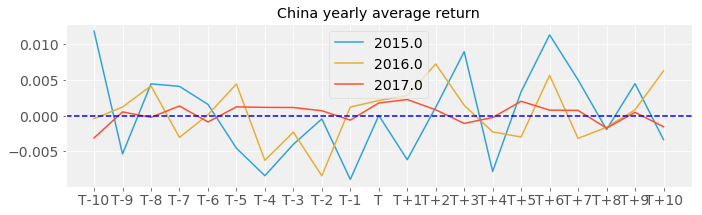

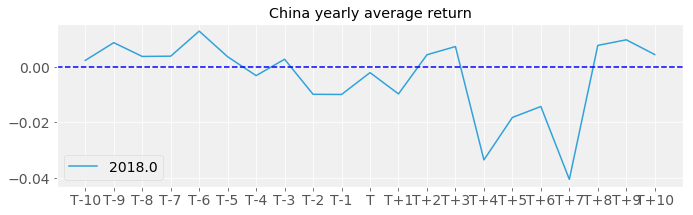

In [34]:
rf_path='./data/DGS3MO.csv'
index_path='./data/000001.SS.csv'
df=data_read_clean(rf_path, index_path)
df_ave=month_rt_get(df)
n=3
ct='China'
df_ave_y=year_rt_plot(df_ave, n, ct)

### General average of the daily excess returns in [T-10, T+10]

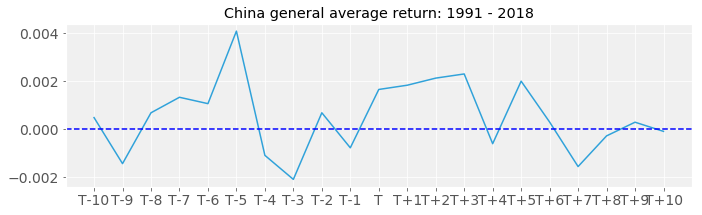

In [35]:
general_rt_plot(df_ave_y, ct)

### The back test of the trading rule

The cum return for China is: 0.450079195176889
The SR for China is: 0.15318491673773857


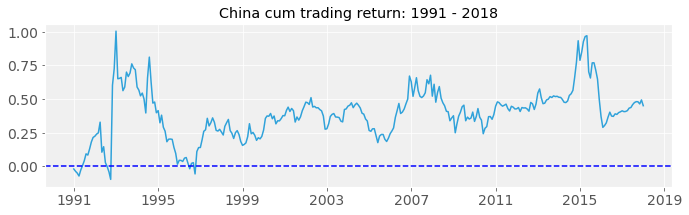

In [36]:
trade_rule(df_ave)